# Tracing Guardrails Quickstart

NeMo Guardrails supports the Open Telemetry ([OTEL](https://opentelemetry.io/)) standard, providing granular visibility into server-side latency. It automatically captures the latency of each LLM and API call, then exports this telemetry using OTEL. You can visualize this latency with any OTEL-compatible backend, including Grafana, Jaeger, Prometheus, SigNoz, New Relic, Datadog, and Honeycomb.

Throughout this notebook, you'll run guardrail requests in both sequential and parallel modes and observe how parallelizing rails significantly reduces end-to-end latency when multiple input or output rails run.

For more information about exporting metrics while using NeMo Guardrails, refer to [Tracing](https://docs.nvidia.com/nemo/guardrails/latest/user-guides/tracing/quick-start.html) in the Guardrails toolkit documentation.

---

## Prerequisites

This notebook requires the following:

- An NVIDIA NGC account and an NGC API key. You need to provide the key to the `NVIDIA_API_KEY` environment variable. To create a new key, go to [NGC API Key](https://org.ngc.nvidia.com/setup/api-key) in the NGC console.
- Python 3.10 or later.

-----

## Install and Import Packages

Before you begin, install and import the following packages that you'll use in the notebook.

In [ ]:
!pip install --upgrade pip

In [2]:
!pip install pandas plotly langchain_nvidia_ai_endpoints aiofiles -q

In [3]:
# Import some useful modules
import os
import pandas as pd
import plotly.express as px
import json

from typing import Dict, List, Any, Union

In [4]:
# Check the NVIDIA_API_KEY environment variable is set
assert os.getenv(
    "NVIDIA_API_KEY"
), f"Please create a key at build.nvidia.com and set the NVIDIA_API_KEY environment variable"

In [5]:
SEQUENTIAL_TRACE_FILE = "sequential_trace.jsonl"
PARALLEL_TRACE_FILE = "parallel_trace.jsonl"

In [6]:
def delete_file_if_it_exists(filename: str) -> None:
    """Check if a file exists, and delete it if so"""

    if os.path.exists(filename):
        print(f"Deleting {filename}")
        os.remove(filename)


delete_file_if_it_exists(SEQUENTIAL_TRACE_FILE)
delete_file_if_it_exists(PARALLEL_TRACE_FILE)

Deleting sequential_trace.jsonl
Deleting parallel_trace.jsonl


------

## Guardrail Configurations

You'll use two configurations for tracing: sequential and parallel.

In the sequential configuration, each input rail is processed one after the other sequentially. If a user input passes all of these input rails successfully, the inference request is then sent to the application LLM to generate a response. After that response is ready, the output rails run in sequence to check both the user's input and the LLM's response. The final response is only returned to the user if all of these checks are successful.

The parallel configuration, on the other hand, runs all input and output rails simultaneously. 

In this notebook, you'll see how the three input rails run in parallel and significantly reduce the end-to-end latency.

### Models Configuration

Store the model configuration required for tracing in the dictionary format as shown below. Each model configuration entry contains `type`, `engine`, and `model` fields:

* **`type`**: This field identifies the task type of a model you want to use. The keyword `main` is reserved for the application LLM, which is responsible for generating a response to the client's request. Any other model names are referenced in the Guardrail flows to build specific workflows.
* **`engine`**: This controls the library used to communicate with the model. The `nim` engine uses [`langchain_nvidia_ai_endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) to interact with NVIDIA-hosted LLMs, while the `openai` engine connects to [OpenAI-hosted models](https://platform.openai.com/docs/models).
* **`model`**: This is the name of the specific model you want to use for the task type.    

In [7]:
CONFIG_MODELS: List[Dict[str, str]] = [
    {
        "type": "main",
        "engine": "nim",
        "model": "meta/llama-3.3-70b-instruct",
    },
    {
        "type": "content_safety",
        "engine": "nim",
        "model": "nvidia/llama-3.1-nemoguard-8b-content-safety",
    },
    {
        "type": "topic_control",
        "engine": "nim",
        "model": "nvidia/llama-3.1-nemoguard-8b-topic-control",
    },
]

### Rails

The `rails` configuration section defines a workflow that executes on every client request. The high-level sections are `input` for input rails, `output` for output rails, and `config` for any additional model condfiguration. Guardrails flows reference models defined in the `CONFIG_MODELS` variable above using the `$model=<model.type>` syntax. The following list describes each section in more detail:

* `input`: Input rails run on the client request only. The config below uses three classifiers to predict whether a user request is safe, on-topic, or a jailbreak attempt. These rails can be run in parallel to reduce the latency. If any of the rails predicts an unsafe input, a refusal text is returned to the user, and no LLM generation is triggered.
* `output`: Output rails run on both client request and the LLM response to that request. The example below checks whether the LLM response to the user request is safe to return. Output rails are needed as well as input because a safe request may give an unsafe response from the LLM if it interprets the request incorrectly. A refusal text is returned to the client if the response is unsafe.
* `config`: Any configuration used outside of a Langchain LLM interface is included in this section. The [Jailbreak detection model](https://build.nvidia.com/nvidia/nemoguard-jailbreak-detect) uses an embedding model as a feature-generation step, followed by a Random Forest classifier to detect a jailbreak attempt.

In [8]:
def config_rails(parallel: bool) -> Dict[str, Any]:
    """Create the rails configuration with programmable parallel setup"""
    return {
        "input": {
            "parallel": parallel,
            "flows": [
                "content safety check input $model=content_safety",
                "topic safety check input $model=topic_control",
                "jailbreak detection model",
            ],
        },
        "output": {"flows": ["content safety check output $model=content_safety"]},
        "config": {
            "jailbreak_detection": {
                "nim_base_url": "https://ai.api.nvidia.com",
                "nim_server_endpoint": "/v1/security/nvidia/nemoguard-jailbreak-detect",
                "api_key_env_var": "NVIDIA_API_KEY",
            }
        },
    }

### Tracing

The tracing configuration configures the adapter and any adapter-specific controls. Here we're storing traces in JSONL format. We'll use a different filename depending on whether we have a sequential or parallel workflow.

In [9]:
def config_tracing(filename: str) -> Dict[str, Any]:
    """Return a Tracing configuration with programmable filename"""
    return {"enabled": True, "adapters": [{"name": "FileSystem", "filepath": filename}]}

## Prompts

Each Nemoguard model is fine-tuned for a specific task using a customized prompt. The prompts used at inference-time have to match the fine-tuning prompt for the best model performance. We'll load these prompts from other locations in the Guardrails repo and show them below.



In [10]:
import yaml


def load_yaml_file(filename: str) -> Dict[str, Any]:
    """Load a YAML file"""

    with open(filename, "r") as infile:
        data = yaml.safe_load(infile)
    return data

In [11]:
content_safety_prompts = load_yaml_file(
    "../../../examples/configs/content_safety/prompts.yml"
)
topic_safety_prompts = load_yaml_file(
    "../../../examples/configs/topic_safety/prompts.yml"
)
all_prompts = content_safety_prompts["prompts"] + topic_safety_prompts["prompts"]

In [12]:
all_prompt_tasks = [prompt["task"] for prompt in all_prompts]
print("Loaded prompt tasks:")
print("\n".join(all_prompt_tasks))

Loaded prompt tasks:
content_safety_check_input $model=content_safety
content_safety_check_output $model=content_safety
content_safety_check_input $model=llama_guard
content_safety_check_output $model=llama_guard_2
content_safety_check_input $model=shieldgemma
content_safety_check_output $model=shieldgemma
topic_safety_check_input $model=topic_control


### Putting All Configurations Together

Use the helper functions, model definitions, and prompts from the above cells and create the sequential and parallel configurations.

In [13]:
SEQUENTIAL_CONFIG = {
    "models": CONFIG_MODELS,
    "rails": config_rails(parallel=False),
    "tracing": config_tracing(filename=SEQUENTIAL_TRACE_FILE),
    "prompts": all_prompts,
}

In [14]:
PARALLEL_CONFIG = {
    "models": CONFIG_MODELS,
    "rails": config_rails(parallel=True),
    "tracing": config_tracing(filename=PARALLEL_TRACE_FILE),
    "prompts": all_prompts,
}

-------

# Tracing Guardrails Requests

In this section of the notebook, you'll create Guardrails using the sequential config file from above. After running inference with Guardrails, you'll examine the traces and relate this to the sequence-of-events when clients make a request to Guardrails.

### Running Sequential Request

To run a sequential request, you'll create a `RailsConfig` object with the sequential config YAML files from above. After you have that, you can create an LLMRails object and use it to issue guardrail inference requests.

In [15]:
import nest_asyncio

# Need to run this command when running in a notebook
nest_asyncio.apply()

In [16]:
from nemoguardrails import RailsConfig, LLMRails

sequential_rails_config = RailsConfig.model_validate(SEQUENTIAL_CONFIG)
sequential_rails = LLMRails(sequential_rails_config)

safe_request = "What is the company policy on PTO?"

response = await sequential_rails.generate_async(
    messages=[
        {
            "role": "user",
            "content": safe_request,
        }
    ]
)

print(response.response)

[{'role': 'assistant', 'content': "Our company policy on Paid Time Off (PTO) is quite comprehensive and designed to support the overall well-being and work-life balance of our employees. According to our HR handbook, all full-time employees are eligible for PTO, which accrues at a rate of 10 days per year for the first two years of service, 15 days per year for years 2-5, and 20 days per year for 5+ years of service.\n\nOur PTO policy includes holidays, vacation days, sick leave, and personal days, all of which can be used to take a break from work, attend to personal matters, or simply recharge. Employees can start accruing PTO from their date of hire, but they cannot use it until they've completed 90 days of employment.\n\nTo ensure a smooth workflow and minimize disruptions, we require employees to provide at least two weeks' notice before taking PTO, whenever possible. However, we understand that unexpected situations may arise, and we're flexible when it comes to last-minute reque

### Running Parallel request

Repeat the same request with the three input rails running in parallel, rather than running sequentially.

In [17]:
from nemoguardrails import RailsConfig, LLMRails

parallel_rails_config = RailsConfig.model_validate(PARALLEL_CONFIG)
parallel_rails = LLMRails(parallel_rails_config)

response = await parallel_rails.generate_async(
    messages=[
        {
            "role": "user",
            "content": safe_request,
        }
    ]
)

print(response.response)

[{'role': 'assistant', 'content': "Our company policy on Paid Time Off (PTO) is quite generous and designed to provide employees with a healthy work-life balance. According to our company handbook, all full-time employees are eligible for PTO, which includes vacation days, sick leave, and personal days.\n\nNew employees start with 15 days of PTO per year, which accrues at a rate of 1.25 days per month. This means that after just one month of employment, you'll already have 1.25 days of PTO available to use. And, as you accumulate more time with the company, your PTO balance will increase. For example, after one year of service, you'll have accrued a total of 15 days of PTO, and after two years, you'll have 20 days of PTO available.\n\nIt's worth noting that our company also observes 10 paid holidays per year, which are separate from your PTO balance. These holidays include New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving Day, and Christmas Day, among others.\n\nI

Now you've run both sequential and parallel Guardrails on an identical request, the trace JSONL files will be created with metrics of latency through the system. Now you can move on and analyze these below.

-------

## Analyze, Visualize, and Compare Guardrails Traces

### Create Helper Functions

The following cells create helper functions to load the sequential and parallel trace files into a Pandas DataFrame for analysis.

In [18]:
import json


def load_trace_file(filename):
    """Load the JSONL format, converting into a list of dicts"""
    data = []
    with open(filename) as infile:
        for line in infile:
            data.append(json.loads(line))
    print(f"Loaded {len(data)} lines from {filename}")
    return data

In [19]:
def load_trace_data(trace_json_filename):
    """Load a trace JSON file, returning pandas Dataframe"""
    trace_data = load_trace_file(trace_json_filename)

    # Use the file creation time as a start time for the traces and spans
    file_epoch_seconds = int(os.path.getctime(trace_json_filename))

    all_trace_dfs = []
    for trace in trace_data:
        trace_id = trace["trace_id"]
        trace_spans = trace["spans"]

        trace_df = pd.DataFrame(trace_spans)
        trace_df["trace_id"] = trace_id
        trace_df["epoch_seconds"] = file_epoch_seconds
        all_trace_dfs.append(trace_df)

    all_trace_df = pd.concat(all_trace_dfs, axis=0)
    return all_trace_df

In [20]:
def clean_trace_dataframe(input_df):
    """Clean the trace dataframe by removing all but the top-level interaction and spans"""

    df = input_df.copy()

    # Add boolean indicators for rails and the top-level span. We only want to keep these
    df["is_rail"] = df["name"] == "guardrails.rail"
    df["is_top_span"] = df["parent_id"].isna()
    row_mask = df["is_rail"] | df["is_top_span"]
    df = df[row_mask].copy()

    # Extract each rail name from the attributes dict. Top-level span doesn't have one
    df["name"] = df["attributes"].apply(lambda x: x.get("rail.name", None))

    # Plotly Gantt charts require a proper datatime rather than relative seconds
    # So use the creation-time of each trace file as the absolute start-point of the trace
    df["start_dt"] = pd.to_datetime(df["start_time"] + df["epoch_seconds"], unit="s")
    df["end_dt"] = pd.to_datetime(df["end_time"] + df["epoch_seconds"], unit="s")

    n_traces = df["trace_id"].nunique()
    assert n_traces == 1, f"Found {n_traces} traces, expected 1. Please re-run notebook"

    # Print out some summary stats on how many spans and rails were found
    n_top_spans = df["is_top_span"].sum()
    n_rail_spans = df["is_rail"].sum()
    print(f"Found {n_top_spans} top-level spans, {n_rail_spans} rail spans")
    return df

### Loading Trace Files

Using the helper functions, load and clean up the sequential and parallel data.

In [21]:
raw_sequential_df = load_trace_data(SEQUENTIAL_TRACE_FILE)
sequential_df = clean_trace_dataframe(raw_sequential_df)

Loaded 1 lines from sequential_trace.jsonl
Found 1 top-level spans, 5 rail spans


In [22]:
sequential_df

,name,span_id,parent_id,start_time,end_time,duration,span_type,span_kind,attributes,events,trace_id,epoch_seconds,is_rail,is_top_span,start_dt,end_dt
0,None,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,None,0.000000,7.403602,7.403602,InteractionSpan,server,"{'span.kind': 'server', 'gen_ai.operation.name...","[{'name': 'guardrails.user_message', 'timestam...",4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,False,True,2025-08-26 16:49:20.000000000,2025-08-26 16:49:27.403602123
1,content safety check input $model=content_safety,911abc24-4111-43b5-90bb-65b521e75f61,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,0.000000,0.450512,0.450512,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,True,False,2025-08-26 16:49:20.000000000,2025-08-26 16:49:20.450512171
4,topic safety check input $model=topic_control,e9113960-9023-46ce-b4ec-e9454ecbfb43,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,0.452292,0.812895,0.360603,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,True,False,2025-08-26 16:49:20.452291965,2025-08-26 16:49:20.812895060
7,jailbreak detection model,dc148a54-4168-46e4-b7fe-9379a7df1102,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,0.814582,1.151427,0.336845,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,True,False,2025-08-26 16:49:20.814581871,2025-08-26 16:49:21.151427031
9,generate user intent,65a93729-16f7-4d5e-86a8-d1f23d842c1a,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,1.159738,6.839181,5.679443,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'genera...",NaN,4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,True,False,2025-08-26 16:49:21.159738064,2025-08-26 16:49:26.839180946
12,content safety check output $model=content_safety,d62875aa-8517-45c0-84fc-6215e018a557,65f79cb5-a93c-4581-94b4-cfeb2bf5a026,6.839181,7.403602,0.564421,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'output...",NaN,4c84db06-e7b7-41b6-b5b4-907cbdfa0232,1756226960,True,False,2025-08-26 16:49:26.839180946,2025-08-26 16:49:27.403602123


In [23]:
raw_parallel_df = load_trace_data(PARALLEL_TRACE_FILE)
parallel_df = clean_trace_dataframe(raw_parallel_df)
parallel_df[["name", "duration"]]

Loaded 1 lines from parallel_trace.jsonl
Found 1 top-level spans, 5 rail spans


,name,duration
0,None,8.248329
1,content safety check input $model=content_safety,0.456112
4,topic safety check input $model=topic_control,0.359808
7,jailbreak detection model,0.330025
9,generate user intent,7.212214
12,content safety check output $model=content_safety,0.577307


In [24]:
parallel_df

,name,span_id,parent_id,start_time,end_time,duration,span_type,span_kind,attributes,events,trace_id,epoch_seconds,is_rail,is_top_span,start_dt,end_dt
0,None,bebb78c1-8788-4f43-96cb-161f9b24077a,None,0.000000,8.248329,8.248329,InteractionSpan,server,"{'span.kind': 'server', 'gen_ai.operation.name...","[{'name': 'guardrails.user_message', 'timestam...",861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,False,True,2025-08-26 16:49:29.000000000,2025-08-26 16:49:37.248328924
1,content safety check input $model=content_safety,97a3d33c-074e-4e95-9fb5-551d5bf2ef4c,bebb78c1-8788-4f43-96cb-161f9b24077a,0.000000,0.456112,0.456112,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,True,False,2025-08-26 16:49:29.000000000,2025-08-26 16:49:29.456111908
4,topic safety check input $model=topic_control,c5fc6e0b-19d5-4d3c-a300-4a1f90f5b2be,bebb78c1-8788-4f43-96cb-161f9b24077a,0.000023,0.359831,0.359808,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,True,False,2025-08-26 16:49:29.000023127,2025-08-26 16:49:29.359831095
7,jailbreak detection model,b206d6c5-fa4a-48dd-a0c9-22bba163759f,bebb78c1-8788-4f43-96cb-161f9b24077a,0.000036,0.330061,0.330025,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'input'...",NaN,861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,True,False,2025-08-26 16:49:29.000035763,2025-08-26 16:49:29.330060959
9,generate user intent,ab6d251e-f919-4e5b-b645-d1a5a025dcf1,bebb78c1-8788-4f43-96cb-161f9b24077a,0.458808,7.671022,7.212214,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'genera...",NaN,861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,True,False,2025-08-26 16:49:29.458808184,2025-08-26 16:49:36.671022177
12,content safety check output $model=content_safety,047b45d9-43d6-4a97-b8c2-764a8d36a7f5,bebb78c1-8788-4f43-96cb-161f9b24077a,7.671022,8.248329,0.577307,RailSpan,internal,"{'span.kind': 'internal', 'rail.type': 'output...",NaN,861c9588-daf4-4006-b8ce-48809ec682f4,1756226969,True,False,2025-08-26 16:49:36.671022177,2025-08-26 16:49:37.248328924


### Analyze Trace Data

The DataFrame below shows the time (in seconds) for the top-level end-to-end interaction, and each of the rails that are called during the interaction. These all run sequentially in this configuration. All input rails have to pass before the user query is passed to the LLM. 

In the DataFrame below, the top-level span is named `interaction`, and represents the end-to-end server-side duration of the `generate_async()` call above. This top-level span comprises 5 rail actions, which are:

 * `rail: content safety check input $model=content_safety'` : Time to check the user input by the [Content-safety Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-content-safety).
 * `rail: topic safety check input $model=topic_control'` : Time to check user input by the [Topic-Control Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-topic-control).
 * `rail: jailbreak detection model'` : Time to check the user input by the [Jailbreak Nemoguard NIM](https://build.nvidia.com/nvidia/nemoguard-jailbreak-detect).
 * `rail: generate user intent'` : Time to generate a response to the user's question from the Main LLM ([Llama 3.3 70B Instruct](https://build.nvidia.com/meta/llama-3_3-70b-instruct)).
 * `rail: content safety check output $model=content_safety` : Time to check the user input and LLM response by the [Content-safety Nemoguard NIM](https://build.nvidia.com/nvidia/llama-3_1-nemoguard-8b-content-safety).

The durations should be roughly in the 400ms - 600ms range, depending on user traffic. The Llama 3.3 70B Instruct model that generates the response is an order of magnitude larger than the NemoGuard models, so it may take up to a minute to generate a response, depending on the cluster load.

#### Analyze Sequential Trace Data

Plot the individual rail times, and a Gantt chart showing start and end-times of each rail.

In [25]:
sequential_df[["is_rail", "is_top_span", "name", "duration"]]

,is_rail,is_top_span,name,duration
0,False,True,None,7.403602
1,True,False,content safety check input $model=content_safety,0.450512
4,True,False,topic safety check input $model=topic_control,0.360603
7,True,False,jailbreak detection model,0.336845
9,True,False,generate user intent,5.679443
12,True,False,content safety check output $model=content_safety,0.564421


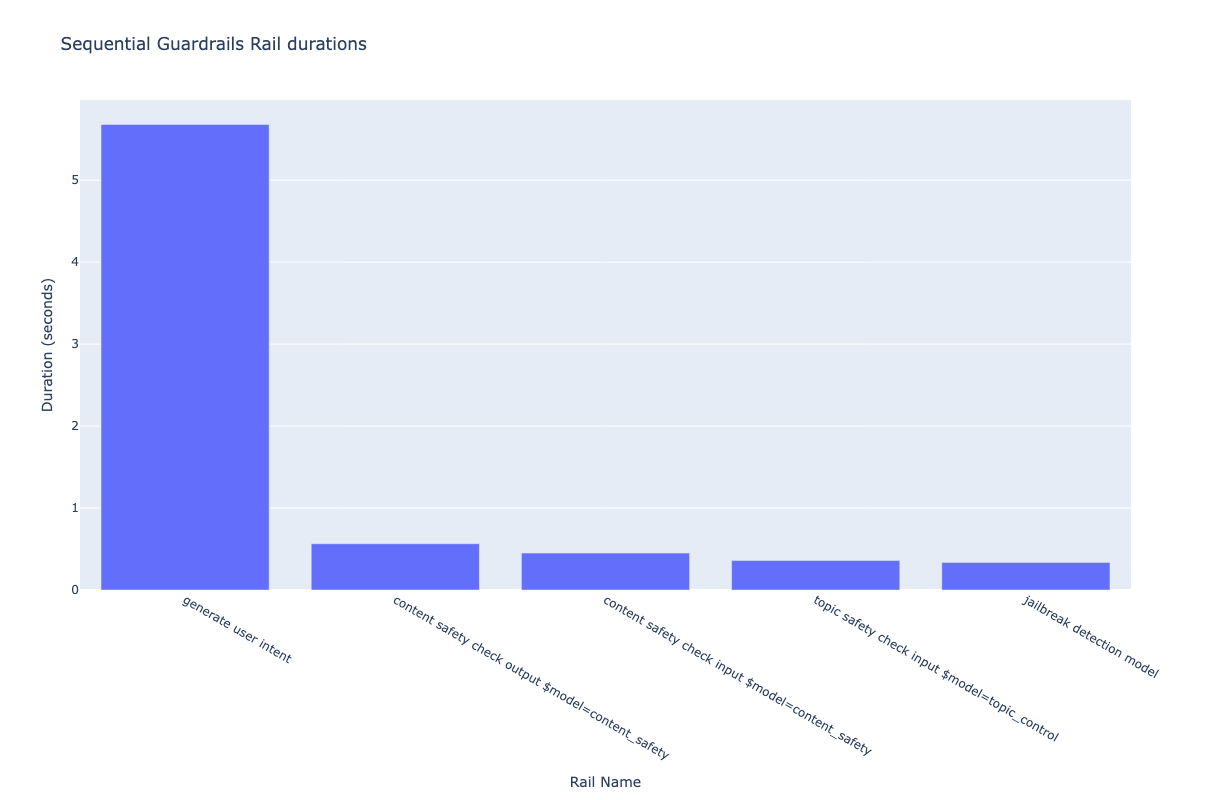

In [26]:
# Now let's plot a bar-graph of these numbers
px.bar(
    sequential_df[sequential_df["is_rail"]].sort_values("duration", ascending=False),
    x="name",
    y="duration",
    title="Sequential Guardrails Rail durations",
    labels={"name": "Rail Name", "duration": "Duration (seconds)"},
    width=800,
    height=800,
)

The Gantt chart below illustrates the sequence of rails in the sequential configuration. All input rails run sequentially as expected. Once these three input rails validate that the user's request is safe, it's sent to the main application LLM. After the main LLM generates a response, the content-safety output rail checks it before it is returned to the user.

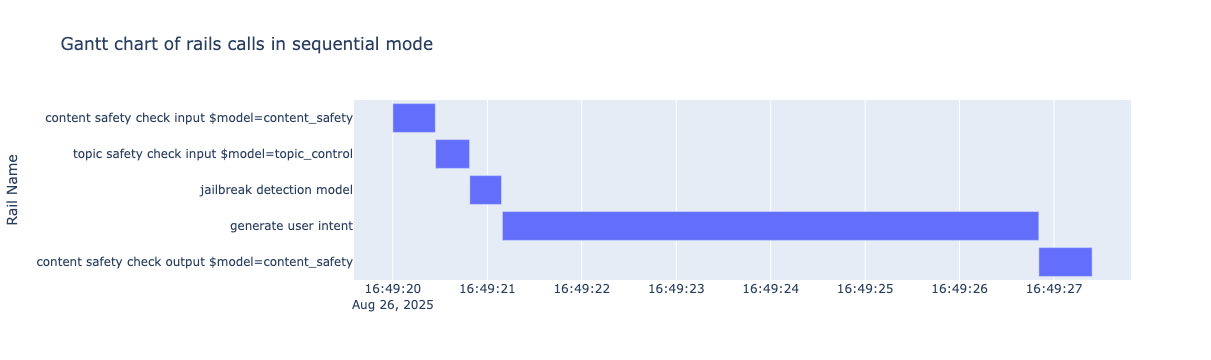

In [27]:
# Let's plot a Gantt chart, to show the sequence of when the rails execute

fig = px.timeline(
    sequential_df.loc[sequential_df["is_rail"]],
    x_start="start_dt",
    x_end="end_dt",
    y="name",
    title="Gantt chart of rails calls in sequential mode",
    labels={"name": "Rail Name"},
)
fig.update_yaxes(autorange="reversed")
fig.show()

#### Analyze Parallel Trace Data

Plot the individual rail times from the parallel rail trace file.

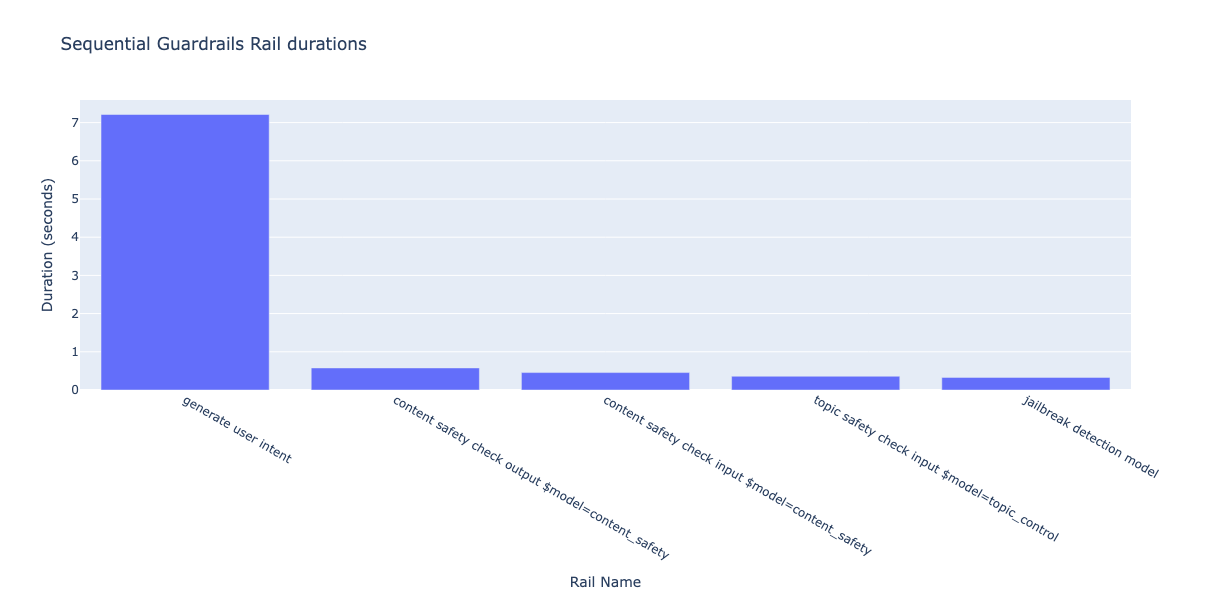

In [28]:
# Now let's plot a bar-graph of these numbers
px.bar(
    parallel_df[parallel_df["is_rail"]].sort_values("duration", ascending=False),
    x="name",
    y="duration",
    title="Sequential Guardrails Rail durations",
    labels={"name": "Rail Name", "duration": "Duration (seconds)"},
    width=800,
    height=600,
)

The Gantt chart below illustrates the sequence of rails in the parallel configuration. All input rails run simultaneously as expected. Once these three input rails validate that the user's request is safe, it's sent to the main application LLM. After the main LLM generates a response, the content-safety output rail checks it before it is returned to the user.

In [29]:
# Let's plot a Gantt chart, to show the sequence of when the rails execute

fig = px.timeline(
    parallel_df.loc[parallel_df["is_rail"]],
    x_start="start_dt",
    x_end="end_dt",
    y="name",
    title="Gantt chart of rails calls in parallel mode",
    labels={"name": "Rail Name"},
    height=400,
    width=1000,
)
fig.update_yaxes(autorange="reversed")
fig.show()

### Compare Sequential and Parallel Trace Data

The following cells compare the input rail times for the sequential and parallel configurations.

In [30]:
INPUT_RAIL_NAMES = {
    "content safety check input $model=content_safety",
    "topic safety check input $model=topic_control",
    "jailbreak detection model",
}

In [31]:
# Final summary of the time-saving due to parallel rails

# Sum the sequential rail run-times
sequential_input_rail_time = sequential_df.loc[
    sequential_df["name"].isin(INPUT_RAIL_NAMES), "duration"
].sum()
print(f"Sequential input rail time: {sequential_input_rail_time:.4f}s")

Sequential input rail time: 1.1480s


In [32]:
# Final summary of the time-saving due to parallel rails
parallel_input_rail_time = parallel_df.loc[
    parallel_df["name"].isin(INPUT_RAIL_NAMES), "duration"
].max()
print(f"Parallel input rail time: {parallel_input_rail_time:.4f}s")
print(
    f"Parallel input speedup: {sequential_input_rail_time / parallel_input_rail_time:.4f} times"
)

Parallel input rail time: 0.4561s
Parallel input speedup: 2.5168 times


-----

# Conclusions

In this notebook, you learned how to trace Guardrails requests in both **sequential** and **parallel** modes. By sending a single request for each mode, you were able to trace and compare their latencies. Using the graphing tools, you visualized the latency breakdown into a table, bar chart, and Gantt chart, providing a clear visual comparison of how each mode performed. The Gantt charts for parallel and sequential rails clearly show the benefit of running all three in parallel, rather than sequentially. For the sample configuration and input request run in this notebook snapshot, parallel mode was ~2.5x faster.